In [3]:
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
%matplotlib inline

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
plt.style.use(["science", "ieee", "grid", "no-latex"])

In [7]:
# Constants
OUTPUT_DIR = Path("results") / "experiments"
OUTPUT_CSV = OUTPUT_DIR / "experiments_results.csv"
IGNORE_CSV = True

In [8]:
# Column configurations for guild compare command
METADATA_COLUMNS = [
    "run",
    "max accuracy",
    "=data.init_args.sampling_weights.diff as diff",
    "=data.init_args.sampling_weights.fam as fam",
    "=data.init_args.sampling_weights.ind as ind",
    "=data.init_args.sampling_weights.rel as rel",
    "=model.init_args.loss.init_args.alpha_neg as alpha_neg",
    "=model.init_args.loss.init_args.tau as tau",
    "=model.init_args.enable_hcl_on as enable_hcl",
]

# Column names after extraction (without the guild syntax)
COLUMNS = [
    "run",
    "accuracy",
    "diff",
    "fam",
    "ind",
    "rel",
    "alpha_neg",
    "tau",
    "enable_hcl",
]

In [9]:
def generate_guild_metadata() -> pd.DataFrame:
    """Generate metadata CSV using Guild AI command and return as DataFrame."""
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    metadata_csv = OUTPUT_DIR / "guild_metadata.csv"

    # Check if metadata file exists
    if metadata_csv.exists() and not IGNORE_CSV:
        print("Reading existing metadata file...")
        df = pd.read_csv(metadata_csv)
    else:
        print("Generating new metadata file...")
        guild_command = [
            "guild",
            "compare",
            "-Fo",
            "scl:train",
            "-Fl",
            "Hyperparameter search",
            "-cc",
            ",".join(METADATA_COLUMNS),
            "--csv",
            str(metadata_csv),
        ]

        try:
            subprocess.run(guild_command, check=True)
            df = pd.read_csv(metadata_csv)
        except subprocess.CalledProcessError as e:
            raise RuntimeError(f"Failed to execute Guild command: {e}")
        except Exception as e:
            raise RuntimeError(f"Failed to process Guild metadata: {e}")

    # Fill NaN values with 0 for hyperparameters
    df = df.fillna(
        {
            "diff": 0,
            "fam": 0,
            "ind": 0,
            "rel": 0,
            "alpha_neg": 0,
            "tau": 0,
            "enable_hcl": 0,
        }
    )

    # Filter experiments based on requirements
    valid_values = [0, 0.25, 1.0]
    df = df[
        (df["diff"].isin(valid_values))
        & (df["fam"].isin(valid_values))
        & (df["ind"].isin(valid_values))
        & (df["rel"].isin(valid_values))
        & (df["enable_hcl"] != 5)
    ]

    return df

In [23]:


def plot_accuracy_vs_hparams(df: pd.DataFrame):
    """Create scatter plots of accuracy vs each hyperparameter."""
    sampling_hparams = ["diff", "fam", "ind", "rel"]
    loss_hparams = ["alpha_neg", "tau", "enable_hcl"]

    # Plot sampling optimization
    fig1, axes1 = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
    plot_group(df, sampling_hparams, axes1, "Sampling Optimization")
    plt.savefig(OUTPUT_DIR / "accuracy_vs_sampling.png", bbox_inches="tight", dpi=600)
    plt.show()

    # Plot loss optimization
    fig2, axes2 = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
    plot_group(df, loss_hparams, axes2, "Loss Optimization")
    plt.savefig(OUTPUT_DIR / "accuracy_vs_loss.png", bbox_inches="tight", dpi=600)
    plt.show()


def plot_group(df, hparams, axes, title):
    """Helper function to plot a group of hyperparameters."""
    # Get top 10 experiments
    top_n_df = df.nlargest(5, "accuracy")

    # Define distinct markers and their labels for top 10
    markers = ["*", "^", "s", "D", "v"]  # , "p", "h", "8", "P", "X"]

    # Create a colormap based on accuracy values
    norm = plt.Normalize(df["accuracy"].min(), df["accuracy"].max())
    cmap = plt.cm.viridis

    # Create subplots for each hyperparameter
    for i, hparam in enumerate(hparams):
        ax = axes[i]

        # Calculate x-axis jitter range based on parameter range
        x_range = df[hparam].max() - df[hparam].min()
        jitter_range = x_range * 0.02  # 2% of parameter range

        # Plot all points with color gradient based on accuracy
        _ = ax.scatter(
            df[hparam],
            df["accuracy"],
            c=df["accuracy"],
            cmap=cmap,
            norm=norm,
            alpha=0.6,
            marker="o",
            s=20,
        )

        # Highlight top 10 experiments with different markers
        for idx, (_, row) in enumerate(top_n_df.iterrows()):
            # Add small random jitter to x-coordinate for better visibility
            jittered_x = row[hparam] + np.random.uniform(-jitter_range, jitter_range)

            ax.scatter(
                jittered_x,
                row["accuracy"],
                c=row["accuracy"],
                cmap=cmap,
                norm=norm,
                marker=markers[idx],
                s=50,
                edgecolor="red",
                linewidth=1.0,
                zorder=5,  # Ensure top experiments are drawn on top
            )

        hparam_label = {
            "alpha_neg": "Similarity Quantile ($s_\\alpha$)",
            "tau": "Temperature ($\\tau$)",
            "enable_hcl": "Epoch HCL started",
            "diff": "Difficulty Weight ($w_d$)",
            "fam": "Family Weight ($w_f$)",
            "ind": "Individual Weight ($w_i$)",
            "rel": "Relationship Weight ($w_r$)",
        }.get(hparam, hparam)

        ax.set_xlabel(f"{hparam_label}", fontsize=12)
        if i == 0:  # Only set ylabel for first subplot
            ax.set_ylabel("Accuracy", fontsize=12)

        # Increase tick label sizes
        ax.tick_params(axis="both", which="major", labelsize=12)

        if hparam == "tau":
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    # # Add colorbar
    # cbar = plt.colorbar(scatter, ax=axes, orientation='vertical', pad=0.02, label='Accuracy')
    # cbar.ax.tick_params(labelsize=10)
    # cbar.set_label('Accuracy', fontsize=12)

    plt.tight_layout()


def format_latex_table(df):
    """Format top 5 results as a LaTeX table."""
    latex_str = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{cccccccc}\n"
    latex_str += "\\toprule\n"
    latex_str += "Acc. & d & f & i & r & $\\alpha$ & $\\tau$ & hcl \\\\\n"
    latex_str += "\\midrule\n"

    for _, row in df.iterrows():
        latex_str += f"{row['accuracy']:.3f} & "
        latex_str += f"{row['diff']:.2f} & "
        latex_str += f"{row['fam']:.2f} & "
        latex_str += f"{row['ind']:.2f} & "
        latex_str += f"{row['rel']:.2f} & "
        latex_str += f"{row['alpha_neg']:.2f} & "
        latex_str += f"{row['tau']:.2f} & "
        latex_str += f"{int(row['enable_hcl'])} \\\\\n"

    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\caption{Top 5 experiments by accuracy}\n"
    latex_str += "\\label{tab:top5}\n"
    latex_str += "\\end{table}"

    return latex_str

In [24]:
def main():
    """Main execution function."""
    # Get metadata from Guild
    df = generate_guild_metadata()

    # Save raw data
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"Raw data saved to {OUTPUT_CSV}")

    # Create plots
    plot_accuracy_vs_hparams(df)
    print(f"Plots saved to {OUTPUT_DIR}/accuracy_vs_sampling.png")
    print(f"Plots saved to {OUTPUT_DIR}/accuracy_vs_loss.png")

    # Print summary statistics
    print("\nSummary Statistics:")
    print(df.describe())

    # Print top 5 experiments by accuracy
    print("\nTop 5 experiments by accuracy:")
    print(df.nlargest(5, "accuracy")[COLUMNS])  # Use clean column names

    # Print LaTeX table
    print("\nLaTeX table format:")
    print(format_latex_table(df.nlargest(5, "accuracy")))

Generating new metadata file...
Raw data saved to results/experiments/experiments_results.csv


Wrote 190 row(s) to results/experiments/guild_metadata.csv


NameError: name 'np' is not defined

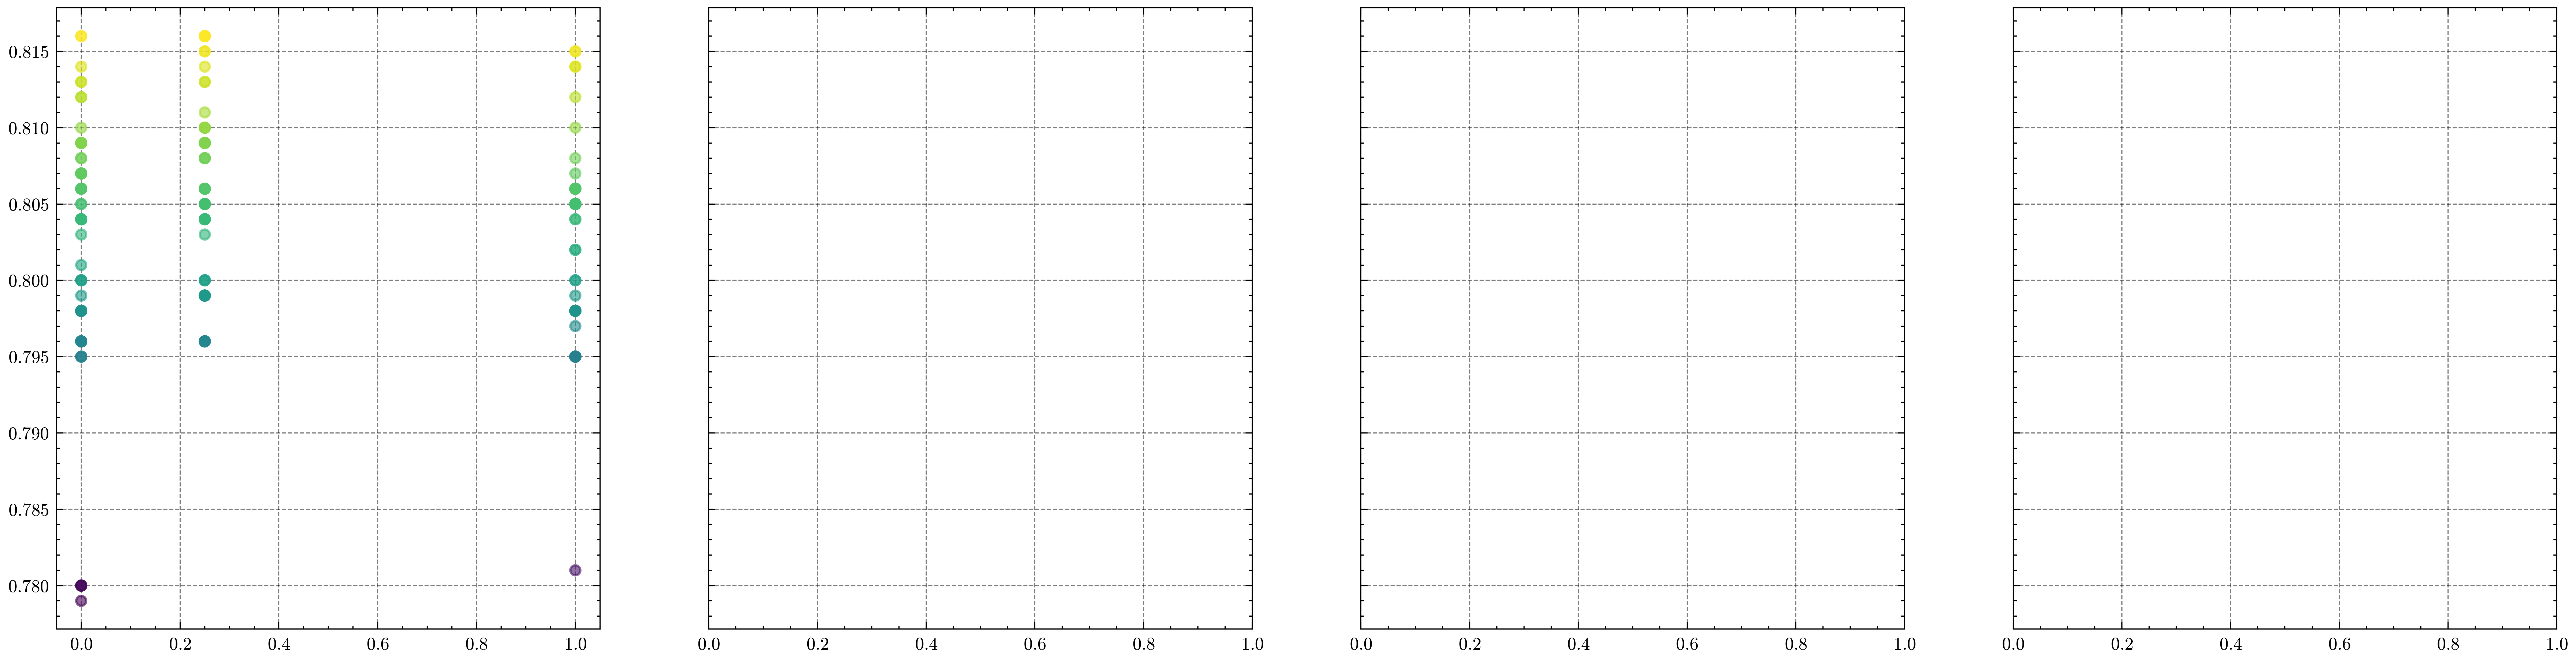

In [25]:
main()

In [ ]:
# Analysis of missing hyperparameter combinations
def analyze_missing_combinations():
    """Analyze which hyperparameter combinations are missing from the experiments."""
    # Load the data
    df = pd.read_csv(OUTPUT_DIR / "guild_metadata.csv")

    # Get unique values for each hyperparameter from the data
    expected_values = {}
    all_params = ["diff", "fam", "ind", "rel", "alpha_neg", "tau", "enable_hcl"]

    for param in all_params:
        if param in df.columns:
            # Round floating point values to handle numerical precision
            unique_vals = df[param].round(3).unique()
            # Sort and remove NaN values
            unique_vals = sorted([x for x in unique_vals if pd.notna(x)])
            expected_values[param] = unique_vals
            print(f"\n{param} unique values: {unique_vals}")

    # Create all possible combinations for sampling weights
    sampling_params = ["diff", "fam", "ind", "rel"]
    mesh = np.meshgrid(*[expected_values[p] for p in sampling_params])
    combinations = np.array([x.flatten() for x in mesh]).T
    sampling_combinations = pd.DataFrame(combinations, columns=sampling_params)

    # Check which combinations are missing
    existing_combinations = df[sampling_params].round(
        3
    )  # Round to handle floating point issues
    missing_combinations = []

    for _, row in sampling_combinations.iterrows():
        combination = row.to_dict()
        exists = False
        for _, existing_row in existing_combinations.iterrows():
            # Compare each parameter individually
            matches = []
            for param in sampling_params:
                diff = abs(float(existing_row[param]) - float(combination[param]))
                matches.append(diff < 0.001)

            if all(matches):  # If all parameters match
                exists = True
                break

        if not exists:
            missing_combinations.append(combination)

    # Print results
    print(
        f"\nTotal possible sampling weight combinations: {len(sampling_combinations)}"
    )
    print(f"Existing combinations: {len(existing_combinations)}")
    print(f"Missing combinations: {len(missing_combinations)}")

    if missing_combinations:
        print("\nMissing combinations:")
        for combo in missing_combinations:
            print(combo)

    # Analyze loss hyperparameters distribution
    print("\nLoss hyperparameters distribution:")
    for param in ["alpha_neg", "tau", "enable_hcl"]:
        if param in df.columns:
            print(f"\nCount of experiments for each {param} value:")
            print(df[param].value_counts().sort_index())

In [ ]:
analyze_missing_combinations()